# Good Reads Capstone 

# TBE: insert Big Picture of a Book

# Part 1: Webscraping

Link: https://www.goodreads.com/shelf/show/currently-reading?page=1

TBE: Insert a screen cap of Good Reads with what I scraped

In [1]:
#Python Libraries for WebScraping
import requests
from bs4 import BeautifulSoup

In [2]:
gr_webpage = requests.get('https://www.goodreads.com/shelf/show/currently-reading?page=1')
soup = BeautifulSoup(gr_webpage.text, 'html.parser')

In [3]:
x = 20 #Set as any number 1~50
book_obj = soup.findAll('a',class_='bookTitle')[x].text
data_title = str(book_obj).split("(")[0].strip()
print(data_title)

Beneath a Scarlet Sky


# Part 2: Database Storage

In [4]:
#Python Libraries for Mongos Database
import pymongo
from pymongo import MongoClient
import pandas as pd


In [5]:
client = MongoClient()
database = client['demonstration']   # Database name (to connect to)
collections = database['gr_demo'] 
try:
    collections.delete_many({})
except:
    pass
collections = database['gr_demo'] # Collection name (to use)

In [6]:
for obj in soup.findAll('div',class_='left')[:5]: #indexed for demonsration
    book_obj = obj.find('a',class_='bookTitle')
    book_title = obj.find('a',class_='bookTitle').text
    data_title = str(book_title).split("(")[0].strip() 
    link_book = "https://www.goodreads.com" + book_obj["href"]
    
    book_read_times = obj.find('a',class_='smallText')
    data_book_currently_reading = int(book_read_times.text.split()[1])

    book_year_ratings = obj.find('span',class_='greyText smallText')
    book_year_ratings_list = book_year_ratings.text.strip().split("\n")
    data_book_year = book_year_ratings_list[2].strip().split()[1]

    author_names = obj.find('a',class_='authorName')
    data_author = author_names.text

    link_author = author_names["href"]
    author_sub_page = requests.get(link_author)
    author_sub_soup = BeautifulSoup(author_sub_page.text, 'html.parser')
    author_birth_place = ""
    for char in author_sub_soup.find("div", class_ = "dataTitle").next_siblings:
        if char.name == "div":
            break
        else:
            author_birth_place += str(char)
            
    birth_country_stripped = author_birth_place.strip().split(",")[-1]
    birth_country_stripped_1 = birth_country_stripped.strip()
    data_birth_country = birth_country_stripped_1.split("\n")[0].strip()
    if data_birth_country[0:3] == "The":
        data_birth_country = data_birth_country[4:].strip()
    elif data_birth_country[0:6] == "in The":
        data_birth_country = data_birth_country[7:].strip()
    elif data_birth_country[0:2] == "in":
        data_birth_country = data_birth_country[3:].strip()
    elif data_birth_country == "":
        data_birth_country = "N/A"
    
    collections.insert_one({"title" : data_title, "author" : data_author, "birth_country" : data_birth_country, "current_readers" : data_book_currently_reading, "book_year": data_book_year})


In [7]:
demo_data = pd.DataFrame(list(collections.find()))
demo_data

,_id,author,birth_country,book_year,current_readers,title
0,5c65f4fc13218a0df221f85a,Jane Austen,England,1813,110672,Pride and Prejudice
1,5c65f4fd13218a0df221f85b,Margaret Atwood,Canada,1985,92704,The Handmaid's Tale
2,5c65f4fd13218a0df221f85c,J.K. Rowling,United Kingdom,1997,86311,Harry Potter and the Sorcerer's Stone
3,5c65f4fe13218a0df221f85d,George R.R. Martin,United States,1996,85480,A Game of Thrones
4,5c65f4fe13218a0df221f85e,George Orwell,India,1949,78600,1984


# Part 3: Exploratory Data Analysis

In [8]:
#Python Libraries for data analysis
import numpy as np
import matplotlib.pyplot as plt

# Exploring the Data

In [9]:
client = MongoClient()
db = client.capstone_1_db
collection = db.good_reads_collections
data = pd.DataFrame(list(collection.find())).set_index("title")[["author", "birth_country", "current_readers", "book_year"]]

In [10]:
data.head()

,author,birth_country,current_readers,book_year
title,,,,
Pride and Prejudice,Jane Austen,England,110672,1813
The Handmaid's Tale,Margaret Atwood,Canada,92704,1985
Harry Potter and the Sorcerer's Stone,J.K. Rowling,United Kingdom,86311,1997
A Game of Thrones,George R.R. Martin,United States,85480,1996
1984,George Orwell,India,78600,1949


In [11]:
grouped_data_country = data.groupby(by= "birth_country")[["birth_country","current_readers"]].sum()
sorted_data_country = grouped_data_country.sort_values("current_readers", ascending = False)

NameError: name 'sorted_data' is not defined

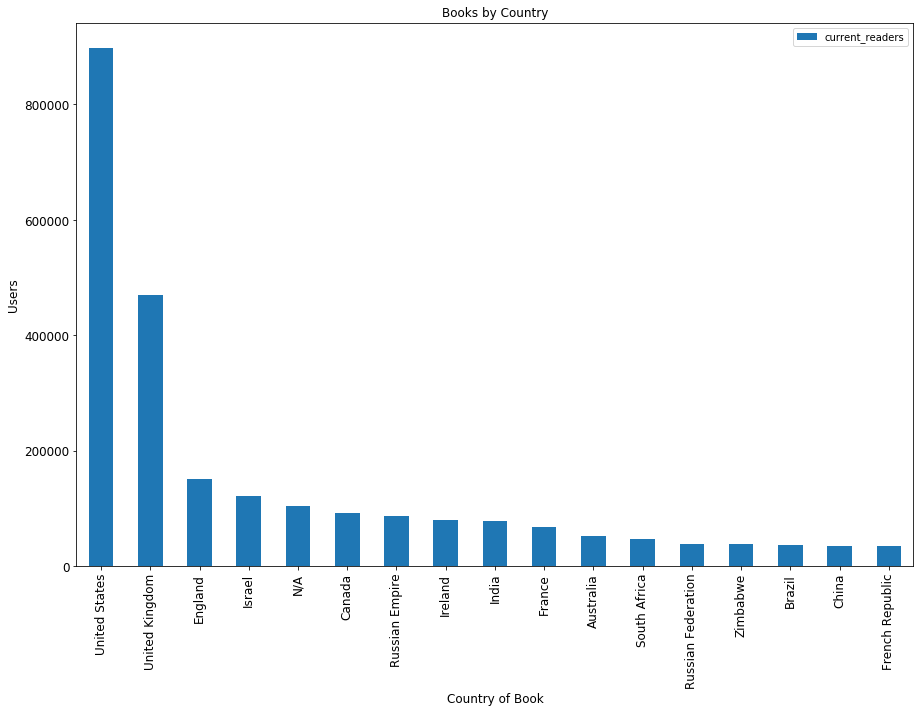

In [12]:
ax = sorted_data_country.plot(kind='bar', title ="Books by Country", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Country of Book", fontsize=12)
ax.set_ylabel("Users", fontsize=12)
for i, v in enumerate(list(sorted_data_country["current_readers"])):
    ax.text(x= i - 0.35, y = v, s = str(v), color='black')
plt.show()

In [ ]:
data_split = data[["book_year", "current_readers"]].sum()
grouped_data_year = data.groupby(by= "book_year")[["current_readers"]].sum()

In [ ]:
ax = grouped_data_year.plot(kind='bar', title ="Books by Country", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Year of Book", fontsize=12)
ax.set_ylabel("Users", fontsize=12)
# for i, v in enumerate(list(sorted_data["current_readers"])):
#     ax.text(x= i - 0.35, y = v, s = str(v), color='black')
plt.show()

In [ ]:
data_split = data[["book_year", "current_readers"]].sum()
grouped_data_year = data.groupby(by= "book_year")[["current_readers"]].sum()
sorted_data_year = grouped_data_year.sort_values("current_readers", ascending = False)

In [ ]:
ax = sorted_data_year.plot(kind='bar', title ="Books by Country", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Year of Book", fontsize=12)
ax.set_ylabel("Users", fontsize=12)
# for i, v in enumerate(list(sorted_data["current_readers"])):
#     ax.text(x= i - 0.35, y = v, s = str(v), color='black')
plt.show()

# Demographics of Goodreaders

In [ ]:
demographics = pd.read_csv("./goodreads_demographics.csv", delimiter = ";")[["count", "name"]]
sliced_demographics = demographics.sort_values("count", ascending = False)[:15].set_index('name')

In [ ]:
ax = sliced_demographics.plot(kind='bar', title ="Demographics", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Country", fontsize=12)
ax.set_ylabel("Users", fontsize=12)
for i, v in enumerate(list(sliced_demographics["count"])):
    ax.text(x= i - 0.35, y = v + 30000, s = str(v), color='black')
plt.show()